<a href="https://colab.research.google.com/github/AmiraliLalehpour/Big-Data-Analytics-Project-2022/blob/main/Copy_of_MMAI_891_NLP_Project_ZINDI_Transformes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries and Data


In [ ]:
!pip install -q transformers tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.1 MB/s eta 0:00:00


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import drive
import os
import re
import string
import gc
import sys

from tqdm.notebook import tqdm

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV, train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical

from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import transformers
from transformers import (AutoTokenizer, AutoModel, AdamW, AutoConfig, get_linear_schedule_with_warmup)

In [ ]:
import locale
print(locale.getpreferredencoding())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

UTF-8


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI 891 NLP/"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
['Copy of MMAI 891 NLP Project ZINDI Transformes.ipynb', 'Project Brief - Zindi Classification.docx', 'Test.csv', 'Train.csv', 'SampleSubmission.csv', 'NLP_Primer_twitter_challenge.ipynb', 'MMAI 891 NLP Project ZINDI Shallow ML.ipynb', 'MMAI 891 NLP Project ZINDI Deep Learning.ipynb', 'Bert_results.csv', 'Bert_model-1.h5', 'test_predictions.csv', 'Bert_results2.csv', 'MMAI 891 NLP Project ZINDI Transformes.ipynb', 'ToVaccineOrNotToVaccine-master']
/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP


In [ ]:
# Load the data
train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data
test = pd.read_csv('Test.csv').fillna('') # Read in test
test['label']=0 # We'll fill this in with predictions later
train.head() # Take a peek at the data

# tsv_data.drop_duplicates(subset="SentenceId", keep="first", inplace=True)

<ipython-input-10-16aca962e813>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [ ]:
test.isnull().sum()

tweet_id     0
safe_text    0
label        0
dtype: int64

In [ ]:
train['label'].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [ ]:
print('The train set has', train.shape,'entries', 'and test set has', test.shape)

The train set has (9999, 4) entries and test set has (5177, 3)


In [ ]:
train.shape[0]

9999

In [ ]:
len(train['label'].unique())

3

In [ ]:
train_df = train.copy()
test_df = test.copy()

In [ ]:
validation_df = pd.DataFrame(train_test_split(train_df, test_size=0.1, random_state=17, shuffle=True))

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [ ]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
print(train_df["label"].isnull().sum())

0


In [ ]:
seqlen = train_df["safe_text"].apply(lambda x: len(x.split()))
print(seqlen.shape)
print('The maximum sequense lengt is:', max(seqlen))

(9999,)
The maximum sequense lengt is: 33


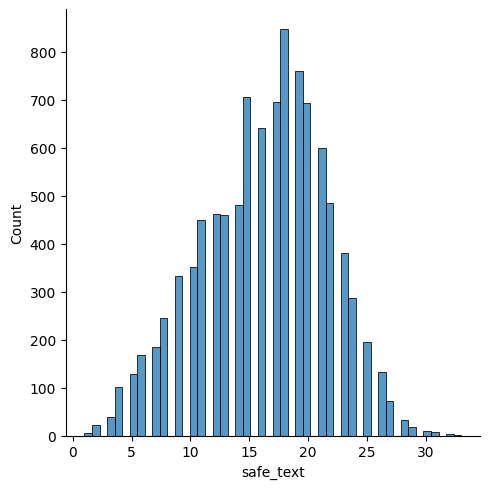

<Figure size 3000x1500 with 0 Axes>

In [ ]:
sns.displot(seqlen)

sns.set_style("darkgrid")
plt.figure(figsize=(30, 15))
plt.show()

# Utilities

In [ ]:
def process_prediction(preds):
  r'''
    This function helps us go from a classifiaction
    problem to a regression one.
    The regression values range are in [-1, 1].
  '''

  final_preds = []
  for pred in preds:
    argmax = np.argmax(pred, axis=0)
    if argmax == 0: final_preds.append( -1*pred[0] )
    elif argmax == 1: final_preds.append( 0 )
    else: final_preds.append( pred[2] )
    
  return final_preds


def rmse(true, pred):
  return np.sqrt(mean_squared_error(true, pred))

# Transfer

In [ ]:
# The maximum seqlen is 33 so 50makes sense to consider as the maximum sequense length for this project. 
SEQ_LEN = 50

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokens = tokenizer.encode_plus("You dumb fuck", max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )

tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101,  1192, 14908,  9367,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
Xids = np.zeros((len(train_df), SEQ_LEN))
Xmask = np.zeros((len(train_df), SEQ_LEN))

Xids.shape, Xmask.shape

((9999, 50), (9999, 50))

In [ ]:
# Make sure you identify the text part of the input as 'text'
def encode_text(text, SEQ_LEN):
  Xids = np.zeros((len(text), SEQ_LEN))
  Xmask = np.zeros((len(text), SEQ_LEN))
  for i, sequence in enumerate(text):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]
  return Xids, Xmask

train_Xids, train_Xmask = encode_text(train_df['safe_text'], SEQ_LEN)
test_Xids, test_Xmask = encode_text(test_df['safe_text'], SEQ_LEN)

# train_Xids[0]

In [ ]:
for i, sequence in enumerate(train_df["safe_text"]):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]

In [ ]:
train_Xids[0]

array([  101.,  2508.,   111.,  1821.,  1643.,   132.,  1109.,  2562.,
        9800.,  9745.,  1928.,  9858., 13144.,  7629.,   108., 22157.,
       14962., 23904.,  3663.,   108., 19443.,   108., 19443.,  1708.,
         108.,   150., 21148.,   108., 23676., 17020.,  8271., 20734.,
       15499.,  2036.,   137.,  1457., 12606.,  1399.,  1457.,   119.,
         133.,   190., 17670.,   135.,   102.,     0.,     0.,     0.,
           0.,     0.])

In [ ]:
train_df["label"].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [ ]:
# # Map the labels to 0, 1, 2 to have them all integers
# value_map = {-1: 0, 0: 1, 1: 2}
# input_list = train_df["label"]
# output_list = [value_map[x] for x in input_list]
# print(output_list)
# train_df["label"] = output_list

In [ ]:
# train_df["label"] = output_list

In [ ]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
arr = train_df["label"].values
labels = np.zeros((arr.size, arr.max()+1))

labels[np.arange(arr.size), arr] = 1
labels

labels

TypeError: ignored

In [ ]:
tf.config.experimental.list_logical_devices("GPU")

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
train_Xids.shape, train_Xmask.shape, labels.shape

((9999, 50), (9999, 50), (9999, 3))

In [ ]:
# make a tensor dataset for the model
dataset = tf.data.Dataset.from_tensor_slices((train_Xids, train_Xmask, labels))

In [ ]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [ ]:
dataset = dataset.map(map_func)

for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,  2508.,   111.,  1821.,  1643.,   132.,  1109.,  2562.,
        9800.,  9745.,  1928.,  9858., 13144.,  7629.,   108., 22157.,
       14962., 23904.,  3663.,   108., 19443.,   108., 19443.,  1708.,
         108.,   150., 21148.,   108., 23676., 17020.,  8271., 20734.,
       15499.,  2036.,   137.,  1457., 12606.,  1399.,  1457.,   119.,
         133.,   190., 17670.,   135.,   102.,     0.,     0.,     0.,
           0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 1., 0.])>)


In [ ]:
dataset = dataset.shuffle(1000000).batch(32)

In [ ]:
DS_LEN = len(dataset)

In [ ]:
SPLIT = 0.9

train_data = dataset.take(round(DS_LEN * SPLIT))
val_data = dataset.skip(round(DS_LEN * SPLIT))

del dataset

In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 50), dtype=tf.float64, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
params = {
          'RANDOM_STATE': 17,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'tanh',
          'DROPOUT_RATE':0.2,
          'LEARNING_RATE': 1e-4,
          'LEARNING_RATE_DECAY':False,
          'CHECKPOINT':True,
          'EPOCHS':100,
          'NUM_CLASSES': len(train['label'].unique()),
          'max_seq_len': 50
}

https://www.kaggle.com/code/anshalsingh/sentiment-analysis

In [ ]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN, ), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(SEQ_LEN, ), name="attention_mask", dtype="int32")

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(256, activation=params["DENSE_ACTIVATION"])(X)
X = tf.keras.layers.Dense(128, activation=params["DENSE_ACTIVATION"])(X)
X = tf.keras.layers.Dropout(params['DROPOUT_RATE'])(X)
X = tf.keras.layers.Dense(128, activation = params["DENSE_ACTIVATION"])(X)
X = tf.keras.layers.Dense(64, activation=params["DENSE_ACTIVATION"])(X)

y = tf.keras.layers.Dense(3, activation="tanh",  name="outputs")(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False


In [ ]:
# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)

# check point - save best model
check_point = ModelCheckpoint(filepath='../model/bert_best_1.hdf5',
                                          monitor='val_root_mean_squared_error',
                                          mode='min',
                                          save_best_only=True
                                          )


# learning rate schedule
lr_start = 0.01

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr_start, params['EPOCHS'])
lr_scheduler = LearningRateScheduler(exponential_decay_fn)
     

callbacks = [early_stopping]

if params['CHECKPOINT']:
  callbacks.append(check_point)
if params['LEARNING_RATE_DECAY']:
  callbacks.append(lr_scheduler)

callbacks

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                          

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")
rmse = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

model.compile(optimizer=optimizer, loss=loss, metrics=[acc, rmse])

In [ ]:
history = model.fit(train_data, 
                   validation_data=val_data,
                   epochs=params["EPOCHS"],
                   callbacks=callbacks
                   )

Epoch 1/100
282/282 [==============================] - 57s 151ms/step - loss: 2.5848 - accuracy: 0.2800 - root_mean_squared_error: 1.0460 - val_loss: 1.7785 - val_accuracy: 0.3272 - val_root_mean_squared_error: 1.0381
Epoch 2/100
282/282 [==============================] - 37s 132ms/step - loss: 2.0235 - accuracy: 0.2796 - root_mean_squared_error: 1.1191 - val_loss: 1.6634 - val_accuracy: 0.2995 - val_root_mean_squared_error: 1.0547
Epoch 3/100
282/282 [==============================] - 37s 131ms/step - loss: 1.3341 - accuracy: 0.3956 - root_mean_squared_error: 1.1446 - val_loss: 1.2358 - val_accuracy: 0.5333 - val_root_mean_squared_error: 1.0762
Epoch 4/100
282/282 [==============================] - 37s 131ms/step - loss: 1.2178 - accuracy: 0.4909 - root_mean_squared_error: 1.1498 - val_loss: 1.1713 - val_accuracy: 0.5108 - val_root_mean_squared_error: 1.0965
Epoch 5/100
282/282 [==============================] - 37s 131ms/step - loss: 1.1559 - accuracy: 0.4855 - root_mean_squared_erro

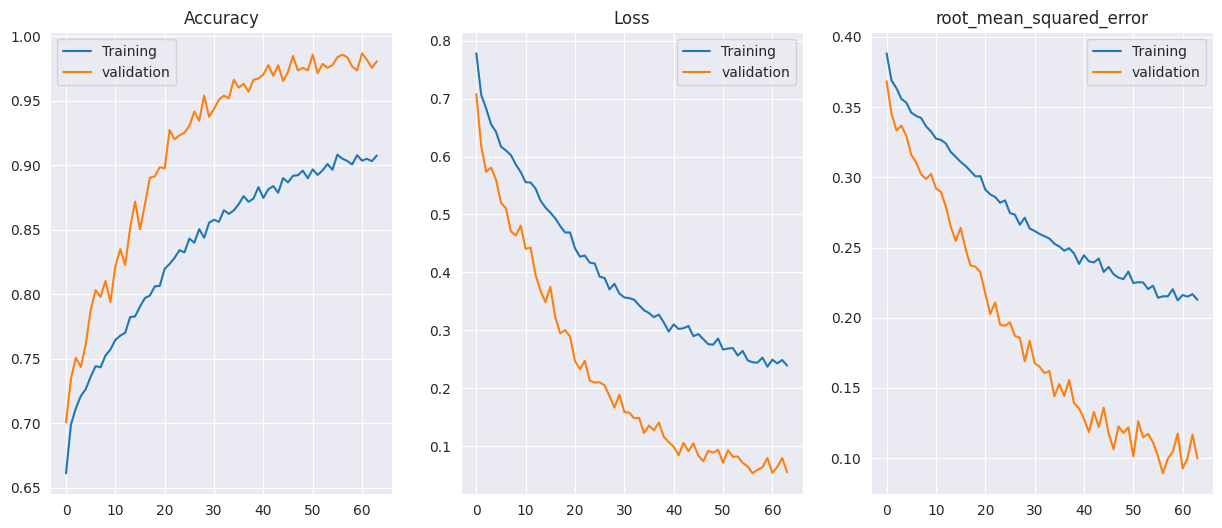

In [ ]:
hist = history
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,3,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')
plt.title("Loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(hist.epoch,hist.history['val_root_mean_squared_error'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_val_root_mean_squared_error'],label = 'validation')
plt.title("root_mean_squared_error")
plt.legend()

plt.show()

In [ ]:
# plot_training(history)

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/Bert_model-1.h5')

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/Bert_model-1.h5')

ValueError: ignored

In [ ]:
test_predictions = model.predict([test_Xids, test_Xmask])

162/162 [==============================] - 18s 111ms/step


In [ ]:
test_loss, test_accuracy, test_rmse = model.evaluate([test_Xids, test_Xmask])

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy, test_rmse))

162/162 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
test loss: 0.0 and test accuracy: 0.0


In [ ]:
print(test_predictions.min(), test_predictions.max())

4.716528e-19 1.0


In [ ]:
test_predictions

array([[6.5047272e-02, 8.1813566e-02, 8.5313910e-01],
       [2.8253969e-02, 3.6486655e-01, 6.0687941e-01],
       [1.7274637e-07, 9.9887079e-01, 1.1290264e-03],
       ...,
       [7.5448640e-03, 7.9884827e-01, 1.9360687e-01],
       [3.2742978e-08, 1.0006603e-07, 9.9999988e-01],
       [2.0517814e-01, 5.4436989e-02, 7.4038488e-01]], dtype=float32)

In [ ]:
Pred_output

In [ ]:
i=0

In [ ]:
test_predictions[i][predicted_class[i]]

0.8531391

In [ ]:
predicted_class[i]

2

In [ ]:
Pred_output=[]
for i in range(len(test_predictions)):
  Pred_output = Pred_output.append(test_predictions[i][predicted_class[i]])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-c65d52c32b2d>", line 3, in <cell line: 2>
    Pred_output = Pred_output.append(test_predictions[i][predicted_class[i]])
AttributeError: 'NoneType' object has no attribute 'append'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context,

In [ ]:
Pred_output

In [ ]:
# # we should scale back the labels to -1 to 1 range.
# # subtract 1 to get the numbers between -1 and 1
# test_predictions = test_predictions - 1
# # scale the numbers to the range of -2 to 2
# test_predictions = test_predictions * 2
# # normalize the values to the range of -1 to 1
# test_predictions = test_predictions / np.max(np.abs(test_predictions))

In [ ]:
predicted_class = np.argmax(test_predictions, axis=1)
print(predicted_class)

[2 2 1 ... 1 2 2]


In [ ]:
print(test_predictions.min(), test_predictions.max())

-1.0 -0.5


In [ ]:
test_predictions[predicted_class].shape

(5177, 3)

In [ ]:
predicted_class = np.argmax(test_predictions, axis=1)
print(predicted_class)

[2 1 1 ... 2 2 2]


In [ ]:
predicted_class

175

In [ ]:
test_pred_labels = np.argmax(test_predictions, axis=1)

In [ ]:
test_pred_labels

array([2, 1, 1, ..., 2, 2, 2])

In [ ]:
# # Map the labels back to -1 to 1 range

# value_map = {0: -1, 1: 0, 2: 1}
# input_list = test_pred_labels
# output_list = [value_map[x] for x in input_list]
# print(output_list)
# test_pred_labels = output_list

[-1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, -1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, -1, -1, 1, -1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, -1, 1, 0, 0, 1, 0, 0, 0, 1, -1, 1, 0, 1, 1, -1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, -1, -1, 0, 1, 0, -1, -1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, -1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, -1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, -1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, -1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, -1, 1

In [ ]:
test_data = test_df.copy()  # create a copy of the DataFrame to avoid warnings
Pred_output = test_data[['tweet_id', 'label']]
test_predictions = np.array([-0.652402, -0.986092, -0.999998, -0.999999, -0.999958])  # example values, replace with your own

if len(test_predictions) == len(Pred_output):
    Pred_output['label'] = test_predictions
    Pred_output.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/Bert_results.csv', encoding='utf-8', index=False, header=True)
else:
    print('Error: Length of test_predictions does not match the number of rows in Pred_output.')


<ipython-input-146-e3a40ec963fe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred_output['label'] = test_predictions


ValueError: ignored

In [ ]:
test_data = test_df

In [ ]:
Pred_output=test_data[['tweet_id','label']]

In [ ]:
Pred_output.head()

,tweet_id,label
0,00BHHHP1,-0.652402
1,00UNMD0E,-0.986092
2,01AXPTJF,-0.999998
3,01HOEQJW,-0.999999
4,01JUKMAO,-0.999958


In [ ]:
Pred_output['label']=np.array(test_predictions)

<ipython-input-142-9500f1d2b56f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred_output['label']=np.array(test_predictions)


In [ ]:
Pred_output = pd.DataFrame({'output_pred': output_list})

In [ ]:
Pred_output.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/Bert_results.csv', encoding='utf-8', index=False, header=True)

ValueError: ignored

In [ ]:
classes = {
    0: "Anti-Vaccine",
    1: "Neutral",
    2: "Pro-Vaccine",
}

In [ ]:
test_data.head()

,tweet_id,safe_text,label
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...,0
1,00UNMD0E,Students starting school without whooping coug...,0
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe...",0
3,01HOEQJW,How many innocent children die for lack of vac...,0
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though...",0


In [ ]:
def map_to_input(sen:str, seq_len:int):
    tokens = tokenizer.encode_plus(sen, max_length=seq_len, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    
    return tokens

In [ ]:
len(test_data)

5177

In [ ]:
final_out = {}

for i in tqdm(range(len(test_data))):
    to_test = test_data["safe_text"].iloc[i]
    test_input = map_to_input(to_test, SEQ_LEN)
    input_ids = test_input["input_ids"]
    mask = test_input["attention_mask"]
    
    pred = model.predict([input_ids, mask], verbose=0)
    final_out[to_test] = classes[np.argmax(pred[0])]

100%|██████████| 5177/5177 [07:06<00:00, 12.15it/s]


In [ ]:
len(test_data)
5177

test_pred = []

for i in tqdm(range(len(test_data))):
    to_test = test_data["safe_text"].iloc[i]
    test_input = map_to_input(to_test, SEQ_LEN)
    input_ids = test_input["input_ids"]
    mask = test_input["attention_mask"]
    
    pred = model.predict([input_ids, mask], verbose=0)
    test_pred.append(classes[np.argmax(pred[0])])

final_out = dict(zip(test_data["safe_text"], test_pred))

len(final_out)
5177

100%|██████████| 5177/5177 [07:04<00:00, 12.20it/s]


5177

In [ ]:
value_map = {'Anti-Vaccine': -1, 'Neutral': 0, 'Pro-Vaccine': 1}
input_list = test_pred
output_pred = [value_map[x] for x in input_list]
print(output_pred)

[-1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, -1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, -1, -1, 1, -1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, -1, 1, 0, 0, 1, 0, 0, 0, 1, -1, 1, 0, 1, 1, -1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, -1, -1, 0, 1, 0, -1, -1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, -1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, -1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, -1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, -1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, -1, 1

In [ ]:
Pred_output

,tweet_id,label
0,00BHHHP1,-1
1,00UNMD0E,1
2,01AXPTJF,0
3,01HOEQJW,1
4,01JUKMAO,0
...,...,...
5172,ZXVVNC5O,1
5173,ZYIANVI8,0
5174,ZYITEHAH,0
5175,ZZ3BMBTG,1


In [ ]:
Pred_output['label']=output_pred

<ipython-input-88-5dd4d2f45bf8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred_output['label']=output_pred


In [ ]:
Pred_output = pd.DataFrame({'output_pred': output_list})

In [ ]:
Pred_output.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/Bert_results.csv', encoding='utf-8', index=False, header=True)

In [ ]:
from google.colab import drive
drive.mount('drive')
# output_list.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/Bert_results.csv', encoding='utf-8', index=False, header=True)
# tar_test_CatBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/cat_CatBoost.csv', encoding='utf-8', index=False, header=True)

ValueError: ignored

In [ ]:
final_out

{'<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk unfortunately.': 'Pro-Vaccine',
 'Students starting school without whooping cough vaccinations <url> #scpick': 'Neutral',
 'I\'m kinda over every ep of <user> being "ripped from the headlines." Measles? Let\'s get back to crime. #SVU': 'Neutral',
 "How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad all their parents couldn't be here. #SB277": 'Pro-Vaccine',
 "CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday they're taking steps… <url>": 'Neutral',
 'I think that active duty soldiers should get vaccines first then anyone who has served then civilians in a disease out break.': 'Pro-Vaccine',
 'New Choices For Seasonal Flu Vaccines: WebMD Health NewsBy Brenda Goodman, MAReviewed by Michael W. Smith,... <url>': 'Neutral',
 "As if the vaccination scares weren't enough, thank you <user> for using scare tactics

# 2.Data Preprocessing

In [ ]:
import nltk
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
train_df = train.copy()

In [ ]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train_df['safe_text'] = train_df['safe_text'].apply(lambda x: clean_text(x))
# test_df['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train_df['safe_text'].head()

0    me amp the big homie  meanboy mb mbs mmr stegm...
1    im  thinking of devoting my career to proving ...
2    whatcausesautism vaccines do not vaccinate you...
3    i mean if they immunize my kid with something ...
4    thanks to  catch me performing at la nuit nyc ...
Name: safe_text, dtype: object

In [ ]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [ ]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train_df['safe_text'] = train_df['safe_text'].apply(lambda x: tokenizer.tokenize(x))
# test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train_df['safe_text'].head()

0    [me, amp, the, big, homie, meanboy, mb, mbs, m...
1    [im, thinking, of, devoting, my, career, to, p...
2    [whatcausesautism, vaccines, do, not, vaccinat...
3    [i, mean, if, they, immunize, my, kid, with, s...
4    [thanks, to, catch, me, performing, at, la, nu...
Name: safe_text, dtype: object

In [ ]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train_df['safe_text'] = train_df['safe_text'].apply(lambda x : remove_stopwords(x))
# test_df['safe_text'] = test['text'].apply(lambda x : remove_stopwords(x))
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,"[amp, big, homie, meanboy, mb, mbs, mmr, stegm...",0.0,1.0
1,E3303EME,"[im, thinking, devoting, career, proving, auti...",1.0,1.0
2,M4IVFSMS,"[whatcausesautism, vaccines, vaccinate, child]",-1.0,1.0
3,1DR6ROZ4,"[mean, immunize, kid, something, wont, secretl...",-1.0,1.0
4,J77ENIIE,"[thanks, catch, performing, la, nuit, nyc, ave...",0.0,1.0


In [ ]:
import nltk

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Stemming and Lemmatization examples: Not always improve reslts, so will not use first. Will try to see after
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [ ]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train_df['safe_text'] = train_df['safe_text'].apply(lambda x : combine_text(x))
# test_df['safe_text'] = test_df['safe_text'].apply(lambda x : combine_text(x))
train_df['safe_text']
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,amp big homie meanboy mb mbs mmr stegmanlife s...,0.0,1.0
1,E3303EME,im thinking devoting career proving autism isn...,1.0,1.0
2,M4IVFSMS,whatcausesautism vaccines vaccinate child,-1.0,1.0
3,1DR6ROZ4,mean immunize kid something wont secretly kill...,-1.0,1.0
4,J77ENIIE,thanks catch performing la nuit nyc ave show s...,0.0,1.0


In [ ]:
# text preprocessing function combining all the steps 
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

# 3. Tokenizing

Bag of words

In [ ]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_df['safe_text'])
# test_vectors = count_vectorizer.transform(test_df["safe_text"])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


TFIDF Features

TF = (Number of times term t appears in a document)/(Number of terms in the document)

IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train_df['safe_text'])
# test_tfidf = tfidf.transform(test_df["safe_text"])

# 4. Basic Model

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0, max_iter=1000, multi_class='auto')
scores = model_selection.cross_val_score(clf, train_vectors, train_df["label"], cv=5)
scores

array([0.7065    , 0.7245    , 0.7295    , 0.7265    , 0.71585793])

In [ ]:
clf.fit(train_vectors, train_df["label"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


LogisticRegression(max_iter=1000, verbose=1)

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0, max_iter=1000, multi_class='auto')
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train_df["label"], cv=5)
scores

array([0.721     , 0.74      , 0.7315    , 0.7325    , 0.71935968])

# Useful Functions

In [ ]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()